In [1]:
import sys
sys.path.append("..") 

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os
import torch.cuda
import albumentations as albu
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.utils.base import Metric
from segmentation_models_pytorch.base.modules import Activation
from collections import defaultdict
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [3]:
from Utils.dataset_utils import *
from Utils.visualization_utils import *

In [4]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [5]:
DATASET_2D_BASE_PATH=Path(r'G:\Documents\LabResearch\POM-microCTproject\MuhammadCollaboration\MiceCT_2Daxials\Axials')
WIDTH=320
HEIGHT=320

In [6]:


def get_training_augmentation():
    train_transform = [
        albu.Resize(HEIGHT, WIDTH),
        albu.ShiftScaleRotate(scale_limit=0.20, rotate_limit=30, shift_limit=0.1, p=1, border_mode=cv2.BORDER_CONSTANT),
        albu.RandomCrop(height=320, width=320),
        albu.Blur(blur_limit=3, p=0.4),
        albu.GaussNoise(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        albu.RandomBrightness(p=0.75)

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.Resize(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [7]:
df_train=load_data(DATASET_2D_BASE_PATH/'train')
df_val=load_data(DATASET_2D_BASE_PATH/'val')
len(df_train)

12288

### Visualization of Augmentations

C:\Users\ns3597\.conda\envs\condaenv\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(16, 320, 320, 3)


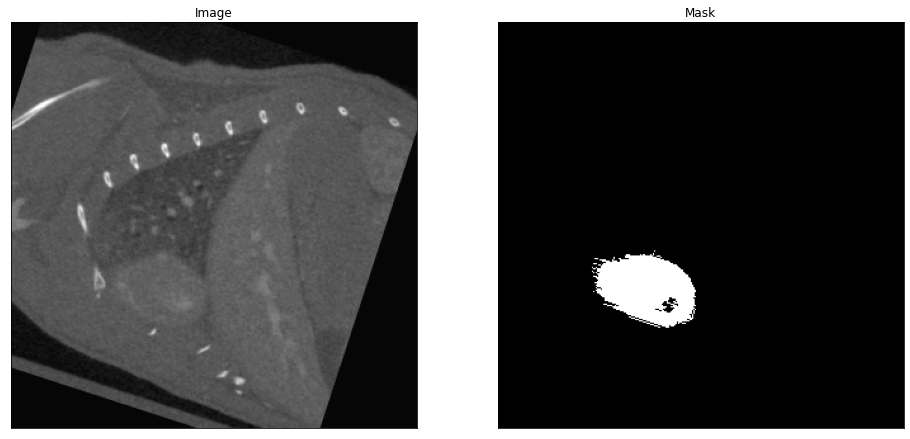

In [8]:
vis_dataset = Dataset(
    df_train['images'], 
    df_train['masks'], 
    augmentation=get_training_augmentation(), 
    )

vis_loader = DataLoader(vis_dataset, batch_size=16, shuffle=True, num_workers=0)
images_batch,masks_batch=next(iter(vis_loader))
print(images_batch.numpy().shape)
idx=np.random.randint(16)


visualize(image=images_batch[idx],mask=masks_batch[idx])


### Training

In [9]:
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
TRAIN_RUNS_PATH=r'G:\Documents\GitHub122121\MicroCTsegmentation\runs'
MODEL_NAME='Unet'
BATCH_SIZE=16
EPOCHS=70


In [10]:
HUMAN_WEIGHTS_PATH=r'G:\Documents\LabResearch\POM-microCTproject\MuhammadCollaboration\HumanCT_2Daxials\TrainedWeights-HumanHeart'

In [11]:
ENCODERS = ['se_resnext50_32x4d','resnet101','efficientnet-b4']

In [12]:
for k in [False,True ]:
    is_human_heart_transfer=k
    for j in range(len(ENCODERS)):
        if is_human_heart_transfer:
            model=torch.load(os.path.join(HUMAN_WEIGHTS_PATH,f'Unet_{ENCODERS[j]}','best.pt'))
        else:
            model = smp.Unet(
            encoder_name=ENCODERS[j], 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=1, 
            activation=ACTIVATION,
            )


        preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODERS[j], ENCODER_WEIGHTS)
        WEIGHTS_PATH=os.path.join(TRAIN_RUNS_PATH,f'{MODEL_NAME}_{ENCODERS[j]}')
        if is_human_heart_transfer:
            WEIGHTS_PATH=WEIGHTS_PATH+'_WHS_Fine_Tuned'

        if os.path.exists(WEIGHTS_PATH)==False:
            os.mkdir(WEIGHTS_PATH)
        else:
            print(f"Warning! Directory {WEIGHTS_PATH } already exists")

        train_dataset = Dataset(
        df_train['images'], 
        df_train['masks'], 
        augmentation=get_training_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn)
        )

        valid_dataset = Dataset(
            df_val['images'], 
            df_val['masks'], 
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(preprocessing_fn)
        ) 

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        loss = smp.utils.losses.DiceLoss()
        metrics = [
            smp.utils.metrics.IoU(threshold=0.5),
            smp.utils.metrics.Fscore()

        ]

        optimizer = torch.optim.Adam([ 
            dict(params=model.parameters(), lr=0.0001),
        ])
        train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
        )

        valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
        )
        min_loss = 100000000
        max_score=-1
        train_history=defaultdict(list)
        valid_history=defaultdict(list)
        if is_human_heart_transfer:
            comment = f'model = {ENCODERS[j]}_WHS_Fine_Tuned'
        else:
            comment = f'model = {ENCODERS[j]}_imagenet'

        tb = SummaryWriter(comment)
    #     images, labels = next(iter(train_loader))
    #     grid = torchvision.utils.make_grid(images)
    #     images=images.to(DEVICE)
    #     tb.add_image("images", grid)
    #     tb.add_graph(model, images)
    #     tb.close()
        for i in range(0, EPOCHS):

            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)

            # do something (save model, change lr, etc.)
            if min_loss > valid_logs['dice_loss']:
                min_loss = valid_logs['dice_loss']
                torch.save(model, os.path.join(WEIGHTS_PATH,f'best_loss_{round(min_loss,4)}.pt'))
                print('Model saved!')
            if max_score <valid_logs['fscore']:
                max_score = valid_logs['fscore']
                torch.save(model, os.path.join(WEIGHTS_PATH,f'best_score_{round(max_score,4)}.pt'))
                print('Model saved!')
                
            if i == 45:
                optimizer.param_groups[0]['lr'] = 1e-5
                print('Decrease decoder learning rate to 1e-5!')
            # Maintain History
            for log_key in train_logs.keys():
                train_history[log_key].append(train_logs[log_key])
                valid_history[log_key].append(valid_logs[log_key])
                tb.add_scalar(f'train_{log_key}',train_logs[log_key], i)
                tb.add_scalar(f'validation_{log_key}',valid_logs[log_key], i)


        del model

        pd.DataFrame(valid_history).to_csv(os.path.join(WEIGHTS_PATH,'validation_logs.csv'))
        pd.DataFrame(train_history).to_csv(os.path.join(WEIGHTS_PATH,'train_logs.csv'))
        print(f"{WEIGHTS_PATH} Completed!!!")
tb.close()


Epoch: 0
valid: 100%|█████████████████| 480/480 [03:34<00:00,  2.23it/s, dice_loss - 0.653, iou_score - 0.6753, fscore - 0.7426]
Model saved!
Model saved!

Epoch: 1
valid: 100%|██████████████████| 480/480 [03:16<00:00,  2.44it/s, dice_loss - 0.6427, iou_score - 0.6726, fscore - 0.74]
Model saved!

Epoch: 2
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.47it/s, dice_loss - 0.6372, iou_score - 0.6673, fscore - 0.7376]
Model saved!

Epoch: 3
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.6215, iou_score - 0.7002, fscore - 0.7666]
Model saved!
Model saved!

Epoch: 4
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.47it/s, dice_loss - 0.6251, iou_score - 0.6926, fscore - 0.7598]

Epoch: 5
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.5954, iou_score - 0.7109, fscore - 0.7803]
Model saved!
Model saved!

Epoch: 6
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.47it/s, dice_loss - 0.5664, iou_score - 0.7111, fsc

valid: 100%|████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.3746, iou_score - 0.6291, fscore - 0.6989]

Epoch: 32
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.3296, iou_score - 0.6478, fscore - 0.7167]

Epoch: 33
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.2732, iou_score - 0.7059, fscore - 0.7759]
Model saved!

Epoch: 34
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2996, iou_score - 0.6921, fscore - 0.7601]

Epoch: 35
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_loss - 0.2457, iou_score - 0.7379, fscore - 0.8025]
Model saved!

Epoch: 36
valid: 100%|█████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.2559, iou_score - 0.721, fscore - 0.7889]

Epoch: 37
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.2295, iou_score - 0.7351, fscore - 0.7988]
Model saved!

Epoch: 38
valid: 100%|████████████████| 480/480 [03:16

valid: 100%|█████████████████| 480/480 [03:16<00:00,  2.45it/s, dice_loss - 0.2356, iou_score - 0.7342, fscore - 0.803]

Epoch: 64
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2272, iou_score - 0.7448, fscore - 0.8123]

Epoch: 65
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_loss - 0.2284, iou_score - 0.7398, fscore - 0.8086]

Epoch: 66
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2394, iou_score - 0.7395, fscore - 0.8075]

Epoch: 67
valid: 100%|█████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_loss - 0.237, iou_score - 0.7413, fscore - 0.8101]

Epoch: 68
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_loss - 0.2429, iou_score - 0.7391, fscore - 0.8064]

Epoch: 69
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_loss - 0.2411, iou_score - 0.7421, fscore - 0.8105]
G:\Documents\GitHub122121\MicroCTsegmentation\runs\Unet_se_resnext50_32x4d Completed!!!


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\ns3597/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]


Epoch: 0
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.6488, iou_score - 0.3131, fscore - 0.3896]
Model saved!
Model saved!

Epoch: 1
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.6145, iou_score - 0.5804, fscore - 0.6472]
Model saved!
Model saved!

Epoch: 2
valid: 100%|████████████████| 480/480 [03:19<00:00,  2.41it/s, dice_loss - 0.5821, iou_score - 0.6006, fscore - 0.6696]
Model saved!
Model saved!

Epoch: 3
valid: 100%|█████████████████| 480/480 [03:19<00:00,  2.41it/s, dice_loss - 0.638, iou_score - 0.3351, fscore - 0.4083]

Epoch: 4
valid: 100%|█████████████████| 480/480 [03:19<00:00,  2.41it/s, dice_loss - 0.6483, iou_score - 0.6231, fscore - 0.688]
Model saved!

Epoch: 5
valid: 100%|█████████████████| 480/480 [03:19<00:00,  2.41it/s, dice_loss - 0.5896, iou_score - 0.6259, fscore - 0.692]
Model saved!

Epoch: 6
valid: 100%|█████████████████| 480/480 [03:19<00:00,  2.41it/s, dice_loss - 0.6902, iou_score - 0.618, fsc

valid: 100%|█████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.341, iou_score - 0.6793, fscore - 0.7445]
Model saved!

Epoch: 32
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.39it/s, dice_loss - 0.3676, iou_score - 0.6556, fscore - 0.7239]

Epoch: 33
valid: 100%|████████████████| 480/480 [03:19<00:00,  2.40it/s, dice_loss - 0.3402, iou_score - 0.6782, fscore - 0.7432]
Model saved!

Epoch: 34
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.3487, iou_score - 0.6773, fscore - 0.7432]

Epoch: 35
valid: 100%|█████████████████| 480/480 [03:20<00:00,  2.39it/s, dice_loss - 0.3107, iou_score - 0.7154, fscore - 0.781]
Model saved!
Model saved!

Epoch: 36
valid: 100%|████████████████| 480/480 [03:19<00:00,  2.40it/s, dice_loss - 0.2804, iou_score - 0.7127, fscore - 0.7773]
Model saved!

Epoch: 37
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.4309, iou_score - 0.5613, fscore - 0.6337]

Epoch: 38
valid: 100%|██████

valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2737, iou_score - 0.7127, fscore - 0.7781]
Model saved!

Epoch: 64
valid: 100%|██████████████████| 480/480 [03:19<00:00,  2.40it/s, dice_loss - 0.271, iou_score - 0.717, fscore - 0.7821]
Model saved!
Model saved!

Epoch: 65
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.39it/s, dice_loss - 0.2848, iou_score - 0.7141, fscore - 0.7799]

Epoch: 66
valid: 100%|████████████████| 480/480 [03:19<00:00,  2.40it/s, dice_loss - 0.2875, iou_score - 0.7062, fscore - 0.7717]

Epoch: 67
valid: 100%|████████████████| 480/480 [03:19<00:00,  2.40it/s, dice_loss - 0.2778, iou_score - 0.7127, fscore - 0.7788]

Epoch: 68
valid: 100%|██████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2655, iou_score - 0.717, fscore - 0.783]
Model saved!
Model saved!

Epoch: 69
valid: 100%|████████████████| 480/480 [03:19<00:00,  2.40it/s, dice_loss - 0.2799, iou_score - 0.7056, fscore - 0.7716]
G:\Documents\GitHub122121\Mic

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to C:\Users\ns3597/.cache\torch\hub\checkpoints\efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]


Epoch: 0
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.6458, iou_score - 0.6906, fscore - 0.7603]
Model saved!
Model saved!

Epoch: 1
valid: 100%|█████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.581, iou_score - 0.7271, fscore - 0.7923]
Model saved!
Model saved!

Epoch: 2
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.39it/s, dice_loss - 0.5524, iou_score - 0.7276, fscore - 0.7922]
Model saved!

Epoch: 3
valid: 100%|████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.5571, iou_score - 0.6194, fscore - 0.6876]

Epoch: 4
valid: 100%|████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.5548, iou_score - 0.7572, fscore - 0.8218]
Model saved!

Epoch: 5
valid: 100%|████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.5455, iou_score - 0.7191, fscore - 0.7843]
Model saved!

Epoch: 6
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.5474, iou_score - 0.6874, fscore - 0.7521]

valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.3215, iou_score - 0.7367, fscore - 0.7985]

Epoch: 32
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2932, iou_score - 0.7803, fscore - 0.8431]
Model saved!

Epoch: 33
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.3236, iou_score - 0.7158, fscore - 0.7789]

Epoch: 34
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.3328, iou_score - 0.7134, fscore - 0.7747]

Epoch: 35
valid: 100%|█████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.3588, iou_score - 0.701, fscore - 0.7644]

Epoch: 36
valid: 100%|████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.3098, iou_score - 0.7372, fscore - 0.8004]

Epoch: 37
valid: 100%|█████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.4118, iou_score - 0.5915, fscore - 0.656]

Epoch: 38
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_lo

valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2521, iou_score - 0.7604, fscore - 0.8227]

Epoch: 64
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2407, iou_score - 0.7623, fscore - 0.8253]

Epoch: 65
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2409, iou_score - 0.7669, fscore - 0.8296]

Epoch: 66
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2521, iou_score - 0.7565, fscore - 0.8192]

Epoch: 67
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2546, iou_score - 0.7616, fscore - 0.8241]

Epoch: 68
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2483, iou_score - 0.7589, fscore - 0.8218]

Epoch: 69
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2416, iou_score - 0.7736, fscore - 0.8357]
G:\Documents\GitHub122121\MicroCTsegmentation\runs\Unet_efficientnet-b4 Completed!!!

Epoch: 0

valid: 100%|████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.2961, iou_score - 0.6451, fscore - 0.7141]

Epoch: 26
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_loss - 0.3016, iou_score - 0.6493, fscore - 0.7155]

Epoch: 27
valid: 100%|█████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.2507, iou_score - 0.7029, fscore - 0.772]

Epoch: 28
valid: 100%|████████████████| 480/480 [03:16<00:00,  2.44it/s, dice_loss - 0.2794, iou_score - 0.6875, fscore - 0.7564]

Epoch: 29
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2752, iou_score - 0.6649, fscore - 0.7353]

Epoch: 30
valid: 100%|████████████████| 480/480 [03:16<00:00,  2.45it/s, dice_loss - 0.2695, iou_score - 0.6819, fscore - 0.7531]

Epoch: 31
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.3009, iou_score - 0.6375, fscore - 0.7078]

Epoch: 32
valid: 100%|████████████████| 480/480 [03:16<00:00,  2.45it/s, dice_loss - 0.2587, 

valid: 100%|█████████████████| 480/480 [03:16<00:00,  2.45it/s, dice_loss - 0.2145, iou_score - 0.7289, fscore - 0.796]

Epoch: 57
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2151, iou_score - 0.7278, fscore - 0.7947]

Epoch: 58
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.46it/s, dice_loss - 0.2051, iou_score - 0.7361, fscore - 0.8027]

Epoch: 59
valid: 100%|████████████████| 480/480 [03:14<00:00,  2.47it/s, dice_loss - 0.2126, iou_score - 0.7296, fscore - 0.7966]

Epoch: 60
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2111, iou_score - 0.7363, fscore - 0.8032]

Epoch: 61
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.46it/s, dice_loss - 0.2089, iou_score - 0.7408, fscore - 0.8076]
Model saved!

Epoch: 62
valid: 100%|█████████████████| 480/480 [03:16<00:00,  2.45it/s, dice_loss - 0.2064, iou_score - 0.736, fscore - 0.8034]

Epoch: 63
valid: 100%|████████████████| 480/480 [03:15<00:00,  2.45it/s, dice_lo

valid: 100%|█████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.349, iou_score - 0.5867, fscore - 0.6563]

Epoch: 19
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2836, iou_score - 0.6755, fscore - 0.7421]

Epoch: 20
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2706, iou_score - 0.6701, fscore - 0.7362]

Epoch: 21
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.39it/s, dice_loss - 0.2273, iou_score - 0.7135, fscore - 0.7803]
Model saved!
Model saved!

Epoch: 22
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2671, iou_score - 0.6935, fscore - 0.7606]

Epoch: 23
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.39it/s, dice_loss - 0.2829, iou_score - 0.6654, fscore - 0.7304]

Epoch: 24
valid: 100%|█████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2876, iou_score - 0.651, fscore - 0.7201]

Epoch: 25
valid: 100%|█████████████████| 480/480 [03:20<00:00,  2.3

valid: 100%|█████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2186, iou_score - 0.7186, fscore - 0.783]

Epoch: 51
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.2063, iou_score - 0.7307, fscore - 0.7949]
Model saved!

Epoch: 52
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.1975, iou_score - 0.7434, fscore - 0.8081]
Model saved!
Model saved!

Epoch: 53
valid: 100%|██████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.199, iou_score - 0.7402, fscore - 0.804]

Epoch: 54
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.1998, iou_score - 0.7407, fscore - 0.8052]

Epoch: 55
valid: 100%|████████████████| 480/480 [03:20<00:00,  2.40it/s, dice_loss - 0.1992, iou_score - 0.7386, fscore - 0.8031]

Epoch: 56
valid: 100%|█████████████████| 480/480 [03:21<00:00,  2.39it/s, dice_loss - 0.2008, iou_score - 0.7363, fscore - 0.801]

Epoch: 57
valid: 100%|████████████████| 480/480 [03:20

valid: 100%|████████████████| 480/480 [03:22<00:00,  2.38it/s, dice_loss - 0.2445, iou_score - 0.6958, fscore - 0.7637]
Model saved!
Model saved!

Epoch: 12
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2678, iou_score - 0.6853, fscore - 0.7516]

Epoch: 13
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2381, iou_score - 0.7051, fscore - 0.7714]
Model saved!
Model saved!

Epoch: 14
valid: 100%|█████████████████| 480/480 [03:23<00:00,  2.36it/s, dice_loss - 0.2379, iou_score - 0.6986, fscore - 0.766]
Model saved!

Epoch: 15
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2611, iou_score - 0.7023, fscore - 0.7671]

Epoch: 16
valid: 100%|████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.2897, iou_score - 0.6688, fscore - 0.7344]

Epoch: 17
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2599, iou_score - 0.7157, fscore - 0.7825]
Model saved!

Epoch: 18
valid

valid: 100%|████████████████| 480/480 [03:25<00:00,  2.34it/s, dice_loss - 0.2592, iou_score - 0.6737, fscore - 0.7429]

Epoch: 44
valid: 100%|████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.2579, iou_score - 0.6819, fscore - 0.7485]

Epoch: 45
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2224, iou_score - 0.7097, fscore - 0.7774]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 46
valid: 100%|█████████████████| 480/480 [03:21<00:00,  2.38it/s, dice_loss - 0.2269, iou_score - 0.706, fscore - 0.7736]

Epoch: 47
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2233, iou_score - 0.7089, fscore - 0.7766]

Epoch: 48
valid: 100%|██████████████████| 480/480 [03:22<00:00,  2.38it/s, dice_loss - 0.2273, iou_score - 0.71, fscore - 0.7771]

Epoch: 49
valid: 100%|████████████████| 480/480 [03:22<00:00,  2.37it/s, dice_loss - 0.2286, iou_score - 0.7067, fscore - 0.7744]

Epoch: 50
valid: 100%|████████████████| 